In [130]:

import simpy
import numpy as np;
from scipy.stats import norm;
from scipy.stats import poisson;

# PEGANDO O SEU CÓDIGO DE BASE PQ A GENTE TEM QUE ESTUDAR PRA MAT DISCRETA ESSE FINAL DE SEMANA PROF xd

# listas de horários de chegada e saída das balanças
chegadas, saidas = [],[]

# listas de horários de chegada e saída das filas
in_queue, in_system  = [],[]

# tempo na fila e tamanho das fulas
horarios_nas_filas, tamanho_da_fila = [],[]

# preparamos o ambiente para EXEMPLO
env = simpy.Environment()
TEMPO_DE_SIMULACAO  = 40   # Tempo
np.random.seed(seed = 1)   # Seed
QUANTIDADE_DE_CAIS = 2     # Quantidade de recursos
MEDIA_CHEGADA_BARCOS = 3
MEDIA_DESCARGA_BARCOS = 9.0
DESVIO_DESCARGA_BARCOS = 3.0
cais_de_descarga = simpy.Resource(env, capacity = QUANTIDADE_DE_CAIS) # prepara o recurso

# Coloração
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


# Salvamos informações da simulação em dado tempo (env_now)
def salva_info_da_fila(env, cais):
    horario_medicao = env.now
    tamanho_da_fila_agora = len(cais.queue)
    horarios_nas_filas.append(horario_medicao)
    tamanho_da_fila.append(tamanho_da_fila_agora)

    return horario_medicao

# Prevê a chegada do caminhão aplicado à uma função probabilística (POISSON)
def dist_chegada_de_barcos():
  tempo_do_proximo_caminhao = poisson.rvs(mu = MEDIA_CHEGADA_BARCOS, size = 1)
  return tempo_do_proximo_caminhao

# Armazena o tempo de saída e calcula a diferença entre a saída e a chegada
def calcula_tempo_no_sistema(env, horario_chegada):
  horario_saida = env.now
  saidas.append(horario_saida)
  tempo_total = horario_saida - horario_chegada
  in_system.append(tempo_total)


# Função que define a  chegada de barcos
def chegada_dos_barcos(env, print_flag :bool):
    # ID para cada barco
    barco_id = 0

    while True:
       # tempo de chegada do proximo barco
       tempo_do_proximo_barco = dist_chegada_de_barcos()
       
       # espera o próximo barco
       yield env.timeout(tempo_do_proximo_barco)

       # barco chegou, guarda as informações
       barco_id += 1
       tempo_de_chegada = env.now
       chegadas.append(tempo_de_chegada)
  
       if print_flag == True : print(f'{bcolors.BOLD}<- %2d {bcolors.ENDC} {bcolors.RED}chegou no cais em %.2f {bcolors.ENDC}' % (barco_id, tempo_de_chegada))
       
       # executa a pesagem
       env.process(descarga(env, barco_id, tempo_de_chegada, print_flag))

       
# Retorna o tempo de pesagem do barco sob uma distribuição  (normal)
def tempo_de_descarga_barco():
  return norm.rvs(loc = MEDIA_DESCARGA_BARCOS, 
                  scale = DESVIO_DESCARGA_BARCOS, 
                  size = 1) # USANDO NORM MESMO

# executa a pesagem do barco
def descarga(env, barco_id, horario_chegada, print_flag: bool):
    
   with cais_de_descarga.request() as req:

        if print_flag == True :print(f'{bcolors.BOLD}<- %2d {bcolors.ENDC} {bcolors.WARNING}entrou na fila em %.2f {bcolors.ENDC}\n' % (barco_id, env.now))
        horario_entrada_da_fila = salva_info_da_fila(env, cais_de_descarga)
        
        yield req # espera a balança ser liberada

        # Execução da descarga do barco
        tempo_descarga = tempo_de_descarga_barco()
        yield env.timeout(tempo_descarga)
        if print_flag == True :print(f'{bcolors.BOLD} %2d -  {bcolors.ENDC} {bcolors.WARNING} permaneceu por %.2f {bcolors.ENDC}' % (barco_id, tempo_descarga))

        if print_flag == True :print(f'{bcolors.BOLD} %2d -> {bcolors.ENDC} {bcolors.OKGREEN} saiu da fila em %.2f {bcolors.ENDC}\n' % (barco_id, env.now))
        horario_saida_da_fila = salva_info_da_fila(env, cais_de_descarga)

        # tempo que ficou na fila
        tempo_na_fila = horario_saida_da_fila - horario_entrada_da_fila
        in_queue.append(tempo_na_fila)



        # tempo total da operacao de pesagem + fila
        calcula_tempo_no_sistema(env, horario_chegada)




env.process(chegada_dos_barcos(env, True))

# Roda a simulação
env.run(until = TEMPO_DE_SIMULACAO)


<-  1  chegou no cais em 2.00 
<-  1  entrou na fila em 2.00 

<-  2  chegou no cais em 3.00 
<-  2  entrou na fila em 3.00 

<-  3  chegou no cais em 6.00 
<-  3  entrou na fila em 6.00 

<-  4  chegou no cais em 7.00 
<-  4  entrou na fila em 7.00 

  2 -    permaneceu por 4.04 
  2 ->   saiu da fila em 7.04 

  1 -    permaneceu por 5.68 
  1 ->   saiu da fila em 7.68 

<-  5  chegou no cais em 10.00 
<-  5  entrou na fila em 10.00 

  4 -    permaneceu por 7.30 
  4 ->   saiu da fila em 14.98 

<-  6  chegou no cais em 15.00 
<-  6  entrou na fila em 15.00 

  3 -    permaneceu por 10.69 
  3 ->   saiu da fila em 17.73 

<-  7  chegou no cais em 20.00 
<-  7  entrou na fila em 20.00 

<-  8  chegou no cais em 25.00 
<-  8  entrou na fila em 25.00 

  5 -    permaneceu por 10.60 
  5 ->   saiu da fila em 25.58 

  6 -    permaneceu por 8.72 
  6 ->   saiu da fila em 26.45 

<-  9  chegou no cais em 28.00 
<-  9  entrou na fila em 28.00 

<- 10  chegou no cais em 30.00 
<- 10  entrou

In [96]:
import matplotlib.pyplot as plt;
import pandas as pd;

df1 = pd.DataFrame(horarios_nas_filas, columns = ['horario'])
df2 = pd.DataFrame(tamanho_da_fila, columns = ['tamanho'])
df3 = pd.DataFrame(chegadas, columns = ['chegadas'])
df4 = pd.DataFrame(saidas, columns = ['partidas'])

df_tamanho_da_fila = pd.concat([df1, df2], axis = 1)
df_entrada_saida = pd.concat([df3, df4], axis = 1)



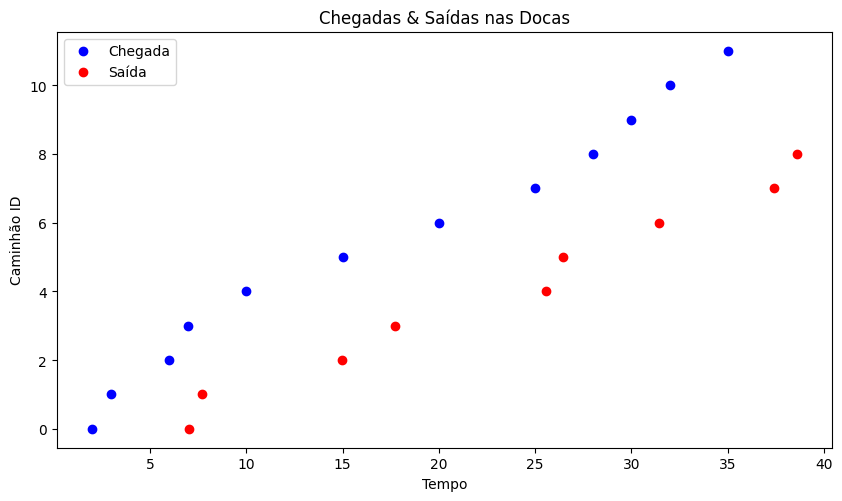

In [131]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 5.4)

y1, x1 = list(df_entrada_saida['chegadas'].keys()), df_entrada_saida['chegadas']
y2, x2 = list(df_entrada_saida['partidas'].keys()), df_entrada_saida['partidas']

ax.plot(x1, y1, color='blue', marker="o", linewidth=0, label="Chegada")
ax.plot(x2, y2, color='red', marker="o", linewidth=0, label="Saída")

ax.set_xlabel('Tempo')
ax.set_ylabel('Caminhão ID')
ax.set_title("Chegadas & Saídas nas Docas")
ax.legend()

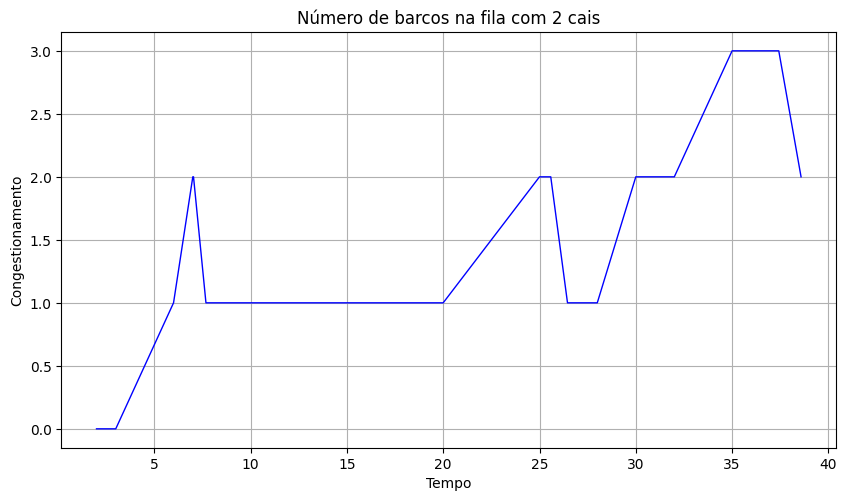

In [132]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5.4)

ax.plot(df_tamanho_da_fila['horario'], df_tamanho_da_fila['tamanho'], color='blue', linewidth=1)
ax.set_xlabel('Tempo')
ax.set_ylabel('Congestionamento')
ax.set_title('Número de barcos na fila com 2 cais')
ax.grid()

In [91]:
## finds the time average number of customers in the waiting line
## use the next row to figure out how long the queue was   
def media_fila(df_tamanho_fila):
  df_tamanho_fila['delta'] = df_tamanho_fila['horario'].shift(-1) - df_tamanho_fila['horario']
  ## drop the last row because it would have an infinite delta time 
  # remote a linha anteruir para não ter delta infinuto
  df_tamanho_fila = df_tamanho_fila[0:-1]
  return np.average(df_tamanho_fila['tamanho'], weights=df_tamanho_fila['delta'])


print('O tempo médio na fila é de %.2f'  % (np.mean(in_queue)))
print('O tempo médio no sistema é %.2f' % (np.mean(in_system)))
print('O número médio de caminhões na fila é %.2f' %  (media_fila(df_tamanho_da_fila)))

O tempo médio na fila é de 10.10
O tempo médio no sistema é 10.10
O número médio de caminhões na fila é 1.28
